In [1]:
!pip3 install pyro_ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 4.3 MB/s 


In [56]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from torchvision.transforms import ToTensor, Lambda

from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam


In [3]:
assert pyro.__version__.startswith('1.8.1') # make sure we have Pyro 1.8.1
pyro.distributions.enable_validation(False) 
pyro.set_rng_seed(0) # make results reproducible
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ 

In [195]:

class TMNISTDataset(Dataset):
    '''
    Typeface MNIST Dataset

    Input: 'path/to/csv/file' (Required)
    Output: torch.utils.data.Dataset
    
    '''
    def __init__(self, csv_file, root_dir='', transform=None, target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))):
        '''
        Args: csv_file (string): Path to the csv file with annotations.    
        '''
        self.tmnist_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        self.target_transform = target_transform
    def __len__(self):
        return len(self.tmnist_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        digits = self.tmnist_frame.iloc[idx, 2:]
        digits = np.array([digits])
        digits = digits.reshape(28,28)
        digits = digits.astype('float32')
        label = self.tmnist_frame.iloc[idx, 1]
        label = np.array([label])
        label = label.astype('int64')

        if self.transform:
            digits = self.transform(digits)

        return digits, label.squeeze()

In [179]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=64, use_cuda=False): 
    root = './data'
    download = True
    # Define transforms
    trans = transforms.ToTensor()
    # train_set = MNIST(root=root, train=True, transform=trans, 
    #                   download=download)
    # test_set = MNIST(root=root, train=False, transform=trans)
    tmnist_dataset = tmnist_dataset = TMNISTDataset("https://raw.githubusercontent.com/prasadshreyas/CS7290-Causal-ML-PyTorch/main/data/TMNIST/TMNIST_Data.csv", transform= transforms.ToTensor() )
    n = len(tmnist_dataset)
    train_length = int(n*0.7)
    test_length = n - train_length
    train_set,test_set = torch.utils.data.random_split( dataset = tmnist_dataset, lengths = [train_length,test_length], generator=torch.Generator().manual_seed(42))
    
    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [180]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim) # 784 = 28 * 28 
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus() # Softplus function is used to make sure the output is positive - RELU

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784) 
        print(x)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [181]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

In [182]:
# define the model p(x|z)p(z)
def model(self, x):
    # register PyTorch module `decoder` with Pyro
    pyro.module("decoder", self.decoder)
    with pyro.plate("data", x.shape[0]):
        # setup hyperparameters for prior p(z)
        z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
        z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
        # sample from prior (value will be sampled by guide when computing the ELBO)
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
        # decode the latent code z
        loc_img = self.decoder(z)
        # score against actual images
        pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

In [183]:
# define the guide (i.e. variational distribution) q(z|x)
def guide(self, x):
    # register PyTorch module `encoder` with Pyro
    pyro.module("encoder", self.encoder)
    with pyro.plate("data", x.shape[0]):
        # use the encoder to get the parameters used to define q(z|x)
        z_loc, z_scale = self.encoder(x)
        # sample the latent code z
        pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

In [184]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img


In [185]:
vae = VAE()
optimizer = Adam({"lr": 1.0e-3})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [186]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [187]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 1
TEST_FREQUENCY = 5

In [188]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

In [189]:

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())


In [194]:

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:248: UserWarning: Encountered NaN: log_prob_sum at site 'obs'
  "log_prob_sum at site '{}'".format(name),
/usr/local/lib/python3.7/dist-packages/pyro/poutine/trace_struct.py:286: UserWarning: Encountered NaN: log_prob_sum at site 'latent'
  site["log_prob_sum"], "log_prob_sum at site '{}'".format(name)
/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


KeyboardInterrupt: ignored

Feature batch shape: torch.Size([256, 1, 28, 28])
Labels batch shape: torch.Size([256])


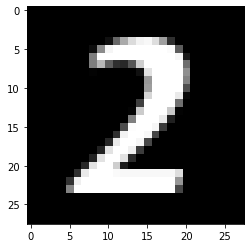

Label: 2


In [193]:
# Loading the dataset
tmnist_dataset = TMNISTDataset("https://raw.githubusercontent.com/prasadshreyas/CS7290-Causal-ML-PyTorch/main/data/TMNIST/TMNIST_Data.csv", transform= transforms.ToTensor())

# Example of a sample
# for i in range(len(tmnist_dataset)):
#     sample = tmnist_dataset[i]
#     print(i, sample[0].shape, sample[1].shape)
#     if i == 1:
#         break

# Creating data loader
dataloader = DataLoader(tmnist_dataset, batch_size=256,
                        shuffle=True)     

# # Quick glance at the batch
# for x, y in dataloader:
#     print(f"Feature batch shape: {x.size()}")
#     print(f"Labels batch shape: {y.size()}")
#     break


# train_features, train_labels = next(iter(

# Building the image grid
train_features, train_labels = next(iter(dataloader))

print(f"Feature batch shape: {train_features.size()}") 
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
import matplotlib.pyplot as plt 
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [191]:
train_features[0].type()

'torch.FloatTensor'

In [192]:
train_labels

tensor([5, 6, 5, 5, 9, 6, 3, 4, 9, 6, 1, 7, 8, 7, 9, 5, 6, 0, 3, 3, 0, 9, 7, 7,
        3, 8, 2, 7, 0, 2, 7, 4, 6, 2, 1, 9, 0, 9, 4, 0, 0, 5, 3, 2, 6, 1, 9, 8,
        0, 1, 0, 5, 2, 2, 1, 7, 6, 3, 7, 6, 3, 4, 9, 0, 8, 8, 1, 3, 7, 6, 7, 6,
        8, 9, 3, 7, 2, 6, 2, 2, 7, 8, 9, 2, 1, 9, 5, 4, 7, 1, 8, 7, 6, 0, 3, 4,
        3, 7, 5, 8, 8, 6, 7, 4, 5, 6, 4, 5, 3, 0, 0, 5, 9, 2, 4, 6, 8, 7, 9, 7,
        0, 0, 3, 7, 4, 8, 8, 7, 8, 8, 8, 4, 8, 3, 0, 8, 7, 6, 5, 7, 2, 9, 9, 7,
        7, 7, 0, 6, 8, 6, 1, 6, 4, 5, 5, 7, 8, 9, 1, 2, 0, 3, 1, 6, 5, 5, 7, 4,
        0, 8, 8, 3, 7, 6, 3, 9, 0, 6, 5, 8, 4, 1, 9, 9, 9, 4, 9, 0, 9, 4, 6, 2,
        0, 1, 4, 3, 4, 9, 4, 8, 7, 9, 1, 5, 7, 1, 5, 5, 6, 8, 6, 8, 1, 4, 0, 3,
        7, 9, 9, 1, 5, 7, 0, 7, 3, 2, 7, 1, 4, 0, 9, 4, 9, 1, 7, 7, 2, 2, 6, 6,
        8, 9, 4, 0, 1, 6, 5, 6, 4, 9, 5, 0, 4, 7, 7, 5])